In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from aeon.visualisation import plot_critical_difference

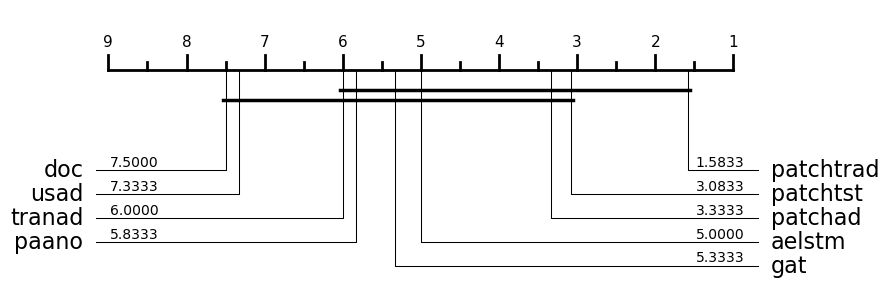

In [3]:
# VUS ROC

results = pd.read_json("results/vus_roc.json")

results_show = results.round(3)
results_show["mean"] = results_show.mean(axis=1).round(3)

results = results.T
methods = results.columns
plot = plot_critical_difference(results.values, methods, alpha=0.05, width=8, test='nemenyi') 
#plt.savefig("results/vus_roc_critical_difference.pdf", format='pdf', bbox_inches='tight')

,nyc_taxi,ec2_request_latency_system_failure,swat,smd,msl,smap,mean
patchtrad,0.933,0.999,0.846,0.890,0.756,0.726,0.858
aelstm,0.715,0.999,0.736,0.856,0.703,0.712,0.787
patchtst,0.884,0.999,0.844,0.901,0.716,0.711,0.843
tranad,0.504,0.988,0.616,0.886,0.732,0.645,0.728
patchad,0.981,0.999,0.686,0.842,0.716,0.734,0.826
gat,0.824,0.999,0.627,0.842,0.710,0.712,0.786
doc,0.740,0.900,0.325,0.768,0.627,0.705,0.678
usad,0.706,0.980,0.206,0.508,0.752,0.600,0.625
paano,0.933,0.974,0.828,0.736,0.714,0.673,0.810


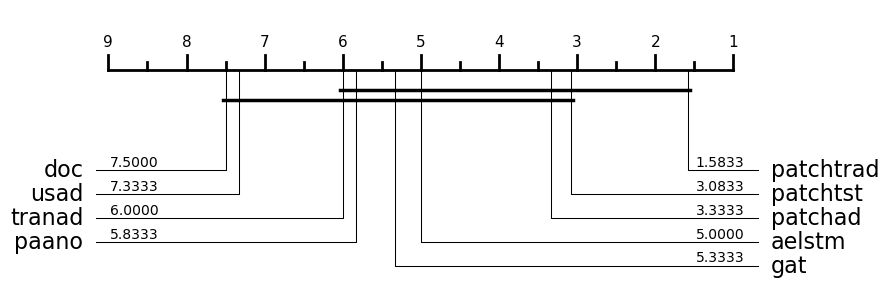

In [6]:
# VUS PR

results = pd.read_json("results/vus_roc.json")

results_show = results.round(3)
results_show["mean"] = results_show.mean(axis=1).round(3)

results = results.T
methods = results.columns
plot = plot_critical_difference(results.values, methods, alpha=0.05, width=8, test='nemenyi') 
#plt.savefig("results/vus_pr_critical_difference.pdf", format='pdf', bbox_inches='tight')
results_show

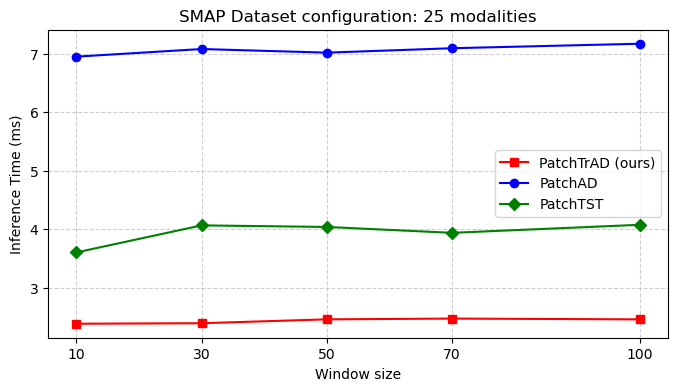

In [ ]:
# Inference Speed for PatchAD, PatchTrAD, TranAD on the SWaT Dataset

import time
import torch
import matplotlib.pyplot as plt
import numpy as np

from models.patchad import PatchADLit
from models.patchtrad import PatchTradLit
from models.patchtst import PatchTSTLit
#from models.catch import CATCHModel

import yaml
from types import SimpleNamespace

DEVICE="cuda"

dataset = "smap"
dataset_config = yaml.safe_load(open(f"conf/dataset/{dataset}.yaml"))
in_dim = dataset_config["in_dim"]

wss = [10, 30, 50, 70, 100]
inference_times = {model: [] for model in ['PatchAD', 'PatchTrAD', 'PatchTST']}
for ws in wss:

    patchad_conf = yaml.safe_load(open(f"conf/dataset_model/patchad/{dataset}.yaml"))
    patchad_conf["ws"]=ws-1
    patchad_conf["len_loader"] = 20
    patchad_conf["in_dim"] = in_dim
    patchad = PatchADLit(SimpleNamespace(**patchad_conf))
    patchtrad_conf = yaml.safe_load(open(f"conf/dataset_model/patchtrad/{dataset}.yaml"))
    patchtrad_conf["ws"]=ws-1
    patchtrad_conf["len_loader"] = 20
    patchtrad_conf["in_dim"] = in_dim
    patchtrad = PatchTradLit(SimpleNamespace(**patchtrad_conf))
    patchtst_conf = yaml.safe_load(open(f"conf/dataset_model/patchtst/{dataset}.yaml"))
    patchtst_conf["ws"]=ws-1
    patchtst_conf["len_loader"] = 20
    patchtst_conf["in_dim"] = in_dim
    patchtst = PatchTSTLit(SimpleNamespace(**patchtst_conf))
    #catch_conf = yaml.safe_load(open("conf/dataset_model/catch/swat.yaml"))
    #catch_conf["ws"]=ws-1
    #catch = CATCHModel(SimpleNamespace(**catch_conf))

    x = torch.randn(1, ws, in_dim)

    models = {
        "PatchAD": patchad,
        "PatchTrAD": patchtrad,
        "PatchTST": patchtst
        }

    def measure_inference_speed(model, x, device="cuda", runs=500):
        x = x.to(device)
        model = model.to(device)
        model.eval()
        # Warm-up
        with torch.no_grad():
            for _ in range(10):
                _ = model.get_loss(x, mode="test")
        
        # Measure inference time
        times = []
        with torch.no_grad():
            for _ in range(runs):
                start = time.time()
                _ = model.get_loss(x, mode="test")
                end = time.time()
                times.append(end - start)
    
        avg_time = np.mean(times) * 1000  
        model = model.cpu()
        return avg_time

    
    for name, model in models.items():
        inference_times[name].append(measure_inference_speed(model, x))

inference_times = {k: v for k, v in zip(['PatchTrAD', 'PatchAD', 'PatchTST'], [inference_times['PatchTrAD'], inference_times['PatchAD'], inference_times['PatchTST']])}

col = {
    "PatchAD": "blue",
    "PatchTrAD": "red",
    "PatchTST": "green",
}
markers = {
    "PatchAD": "o",
    "PatchTrAD": "s",
    "PatchTST": "D",
}

plt.figure(figsize=(8, 4))

for name, values in inference_times.items():
    # different color and linestyle for each model
    plt.plot(wss, values, label=name+" (ours)" if name=="PatchTrAD" else name, color=col[name], linestyle='-', marker=markers[name])
# patchtrad above in legend
plt.legend(fontsize=10)
plt.xticks(wss) 
plt.xlabel("Window size")
plt.ylabel("Inference Time (ms)")
plt.title(f"SMAP Dataset configuration: {in_dim} modalities")
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("infspeed_smap.pdf", bbox_inches="tight")

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

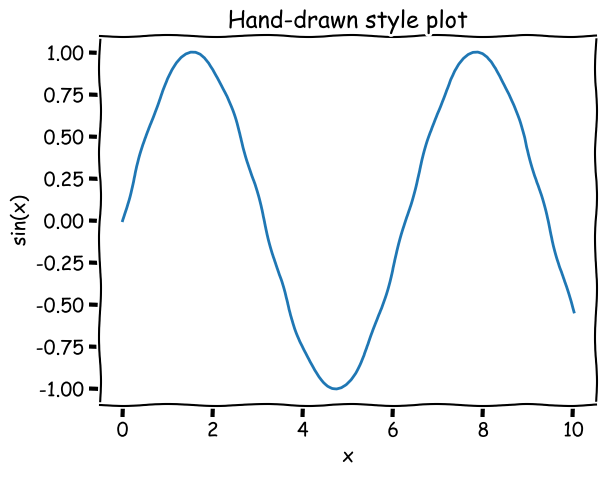

In [7]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 100)
y = np.sin(x)

with plt.xkcd():
    plt.plot(x, y)
    plt.title("Hand-drawn style plot")
    plt.xlabel("x")
    plt.ylabel("sin(x)")
    plt.show()